In [5]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np

from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import PrioritisedReplayBuffer
from fab import Trainer, PrioritisedBufferTrainer
from fab.utils.plotting import plot_contours, plot_marginal_pair
from experiments.make_flow import make_wrapped_normflow_realnvp
import importlib 
import models.ddpm
importlib.reload(models.ddpm)
from models.ddpm import GaussianDiffusion, TMLP

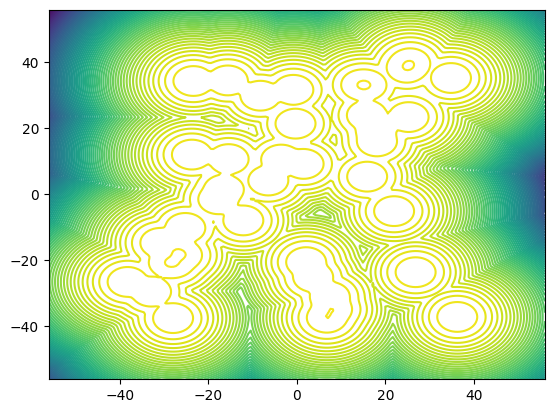

In [31]:
dim = 2
n_mixes = 40
loc_scaling = 40.0  # scale of the problem (changes how far apart the modes of each Guassian component will be)
log_var_scaling = 1.0 # variance of each Gaussian
seed = 0

torch.manual_seed(0)  # seed of 0 for GMM problem
target = GMM(dim=dim, n_mixes=n_mixes,
              loc_scaling=loc_scaling, log_var_scaling=log_var_scaling,
              use_gpu=True, true_expectation_estimation_n_samples=int(1e5))
# plot target
target.to("cpu")
fig, ax = plt.subplots()
plotting_bounds = (-loc_scaling * 1.4, loc_scaling * 1.4)
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=80, ax=ax, grid_width_n_points=200)
target.to("cuda")

In [32]:
# hyper-parameters

# Flow
n_flow_layers = 15
layer_nodes_per_dim = 40
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 128
n_iterations = 4000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 10 # number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0

# AIS
# By default we use a simple metropolis mcmc transition with a fixed step size.
# Can switch this to 'hmc' to improve training efficiency. 
transition_operator_type = "metropolis" 
n_intermediate_distributions = 1
metropolis_step_size = 5.0

# buffer config
n_batches_buffer_sampling = 4
maximum_buffer_length = batch_size * n_batches_buffer_sampling * 100
min_buffer_length = batch_size * n_batches_buffer_sampling * 10

# target p^\alpha q^{a-\alpha} as target for AIS. 
min_is_target = True
p_target = not min_is_target # Whether to use p as the target. 

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = TMLP(dim = 2).to(device)

diffusion = GaussianDiffusion(
    model,
    image_size = 2,
    timesteps = 1000    # number of steps
).to(device)

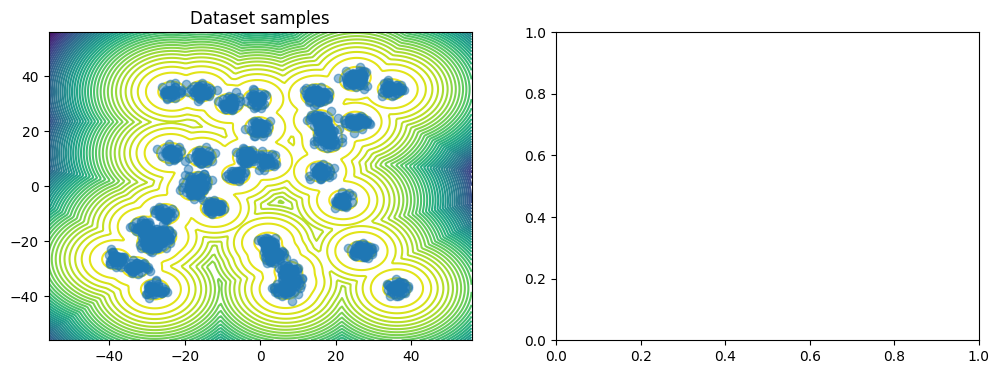

[<Figure size 1200x400 with 2 Axes>]

In [34]:
num_samples = 2048
dataset = target.sample(torch.tensor(2048).unsqueeze(0))
def plot_dataset(samples):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    target.to("cpu")
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=50, grid_width_n_points=200)
    target.to("cuda")
   
    # plot dataset samples
    plot_marginal_pair(samples, ax=axs[0], bounds=plotting_bounds)
    
    axs[0].set_title("Dataset samples")
    plt.show()
    return [fig]

plot_dataset(dataset) # Visualise model during initialisation.

In [35]:
import pdb

def normalize(x):
    '''
        normalizes to [-1, 1]
    '''
    mins = torch.min(x, dim=0)[0]
    maxs = torch.max(x, dim=0)[0]
    ## [ 0, 1 ]
    x = (x - mins) / (maxs - mins + 1e-5)
    ## [ -1, 1 ]
    x = x * 2 - 1
    return x, mins, maxs

def unnormalize(x, mins, maxs):
    '''
        x : [ 0, 1 ]
    '''
    assert x.max() <= 1 and x.min() >= 0, f'x range: ({x.min():.4f}, {x.max():.4f})'
    mins = to_tensor(mins, dtype=x.dtype, device=x.device)
    maxs = to_tensor(maxs, dtype=x.dtype, device=x.device)
    return x * (maxs - mins) + mins


In [36]:
# Training Loop
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
opt = Adam(diffusion.parameters())
num_train_epochs = 100
dataset, global_mins, globals_maxs = normalize(torch.tensor(dataset))
train_dataset = TensorDataset(dataset)
train_loader = DataLoader(train_dataset, batch_size = 256, shuffle=True) 

/tmp/ipykernel_126315/3172244883.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset, global_mins, globals_maxs = normalize(torch.tensor(dataset))


In [37]:
for epoch in range(num_train_epochs):
    total_loss = 0.
    print(epoch)
    for i, data in enumerate(train_loader):
        data = data[0].to(device)
        opt.zero_grad()
        loss = diffusion(data)    
        total_loss += loss.item()
        loss.backward()
        opt.step()

0


ValueError: not enough values to unpack (expected 6, got 4)